# Python: Conditional Average Treatment Effects (CATEs)

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate conditional average treatment effects with B-splines for one or two-dimensional effects.

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from this [paper](https://arxiv.org/abs/1806.03467) and this implementation from [EconML](https://github.com/microsoft/EconML).

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

The data is generated as

$
\begin{align}
Y_i & = g(X_i)T_i + \langle W_i,\gamma_0\rangle + \epsilon_i \\
T_i & = \langle W_i,\beta_0\rangle +\eta_i,
\end{align}
$

where $W_i\sim\mathcal{N}(0,I_{d_w})$, $X_i\sim\mathcal{U}[0,1]^{d_x}$ and $\epsilon_i,\eta_i\sim\mathcal{U}[0,1]$.
The coefficient vectors $\gamma_0$ and $\beta_0$ both have small random support which values are drawn independently from $\mathcal{U}[0,1]$.
Further, $g(x)$ defines the conditional treatment effect, which is defined differently depending on the dimension of $x$.

If $x$ is univariate the conditional treatment effect takes the following form

$$ g(x) = \exp(2x) + 3\sin(4x),$$

whereas for a two-dimensional variable $x=(x_1,x_2)$ the conditional treatment effect is defined as

$$ g(x) = \exp(2x_1) + 3\sin(4x_2).$$

In [2]:
def treatment_effect_1d(x):
    te = np.exp(2 * x) + 3 * np.sin(4 * x)
    return te

def treatment_effect_2d(x):
    te = np.exp(2 * x[0]) + 3 * np.sin(4 * x[1])
    return te

def create_synthetic_data(n_samples=200, n_w=30, support_size=5, n_x=1):
    """
    Creates a simple synthetic example for conditional treatment effects.

    Parameters
    ----------
    n_samples : int
        Number of samples.
        Default is ``200``.

    n_w : int
        Dimension of covariates.
        Default is ``30``.

    support_size : int
        Number of relevant covariates.
        Default is ``5``.

    n_x : int
        Dimension of treatment variable.
        Default is ``1``.

    Returns
    -------
     data : pd.DataFrame
            A data frame.

    """
    # Outcome support
    # With the next two lines we are effectively choosing the matrix gamma in the example
    support_y = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_y = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)
    # Treatment support
    # Assuming the matrices gamma and beta have the same non-zero components
    support_t = support_y
    coefs_t = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    eta_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)

    # Generate controls, covariates, treatments and outcomes
    w = np.random.normal(0, 1, size=(n_samples, n_w))
    x = np.random.uniform(0, 1, size=(n_samples, n_x))
    # Heterogeneous treatment effects
    if n_x == 1:
        te = np.array([treatment_effect_1d(x_i) for x_i in x]).reshape(-1)
    elif n_x == 2:
        te = np.array([treatment_effect_2d(x_i) for x_i in x]).reshape(-1)
    # Define treatment
    log_odds = np.dot(w[:, support_t], coefs_t) + eta_sample(n_samples)
    t_sigmoid = 1 / (1 + np.exp(-log_odds))
    t = np.array([np.random.binomial(1, p) for p in t_sigmoid])
    # Define the outcome
    y = te * t + np.dot(w[:, support_y], coefs_y) + epsilon_sample(n_samples)

    # Now we build the dataset
    y_df = pd.DataFrame({'y': y})
    if n_x == 1:
        x_df = pd.DataFrame({'x': x.reshape(-1)})
    elif n_x == 2:
        x_df = pd.DataFrame({'x_0': x[:,0],
                             'x_1': x[:,1]})
    t_df = pd.DataFrame({'t': t})
    w_df = pd.DataFrame(data=w, index=np.arange(w.shape[0]), columns=[f'w_{i}' for i in range(w.shape[1])])

    data = pd.concat([y_df, x_df, t_df, w_df], axis=1)

    covariates = list(w_df.columns.values) + list(x_df.columns.values)
    return data, covariates, te

## One-dimensional Example

We start with $X$ being one-dimensional and create our training data.

In [3]:
# DGP constants
np.random.seed(42)
n_samples = 2000
n_w = 10
support_size = 5
n_x = 1

# Create data
data, covariates, true_effect = create_synthetic_data(n_samples=n_samples, n_w=n_w, support_size=support_size, n_x=n_x)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='y',
                                 d_cols='t',
                                 x_cols=covariates)

Next, define the learners for the nuisance functions and fit the [IRM Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html). Remark that the learners are not optimal for the linear form of this example.

In [4]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

Training IRM Model


To estimate the CATE, we rely on the best-linear-predictor of the linear score as in [Semenova et al.](https://doi.org/10.1093/ectj/utaa027) To approximate the target function $g(x)$ with a linear form, we have to define a data frame of basis functions. Here, we rely on [patsy](https://patsy.readthedocs.io/en/latest/) to construct a suitable basis of [B-splines](https://en.wikipedia.org/wiki/B-spline).

In [5]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=2)", {"x":data["x"]})
spline_basis = pd.DataFrame(design_matrix)

To estimate the parameters to calculate the CATE estimate call the ``cate()`` method and supply the dataframe of basis elements.

In [6]:
cate = dml_irm.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t          P>|t|    [0.025    0.975]
0  0.803842  0.187175   4.294598   1.834144e-05  0.436763  1.170921
1  2.313014  0.312769   7.395278   2.066986e-13  1.699626  2.926402
2  4.728587  0.199944  23.649585  3.356811e-109  4.336467  5.120708
3  4.498873  0.239346  18.796495   1.070486e-72  4.029478  4.968268
4  3.860540  0.245883  15.700725   1.816059e-52  3.378326  4.342755
5  4.111399  0.266502  15.427289   8.201758e-51  3.588748  4.634050


To obtain the confidence intervals for the CATE, we have to call the ``confint()`` method and a supply a dataframe of basis elements.
This could be the same basis as for fitting the CATE model or a new basis to e.g. evaluate the CATE model on a grid.
Here, we will evaluate the CATE on a grid from 0.1 to 0.9 to plot the final results.
Further, we construct uniform confidence intervals by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [7]:
new_data = {"x": np.linspace(0.1, 0.9, 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   2.161524  2.486687  2.811850
1   2.280143  2.606998  2.933854
2   2.394160  2.724940  3.055721
3   2.504567  2.840513  3.176460
4   2.612210  2.953717  3.295225
..       ...       ...       ...
95  4.479230  4.810769  5.142308
96  4.482378  4.808534  5.134690
97  4.486453  4.807426  5.128399
98  4.490813  4.807445  5.124076
99  4.494702  4.808590  5.122478

[100 rows x 3 columns]


Finally, we can plot our results and compare them with the true effect.

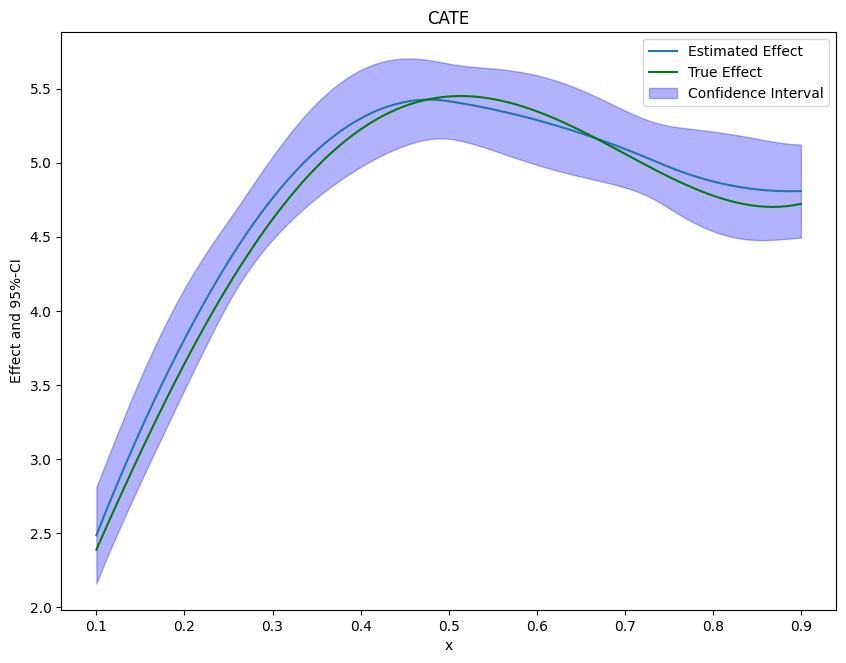

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['x']
df_cate['true_effect'] = treatment_effect_1d(new_data['x'])
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['true_effect'], color="green", label='True Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

## Two-Dimensional Example

It is also possible to estimate multi-dimensional conditional effects. We will use the same data-generating process as above, but let $X$ be two-dimensional.

In [9]:
# DGP constants
np.random.seed(42)
n_samples = 5000
n_w = 10
support_size = 5
n_x = 2

In [10]:
# Create data
data, covariates, true_effect = create_synthetic_data(n_samples=n_samples, n_w=n_w, support_size=support_size, n_x=n_x)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='y',
                                 d_cols='t',
                                 x_cols=covariates)

As univariate example estimate the [IRM Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html).

In [11]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(123)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

Training IRM Model


As above, we will rely on the [patsy](https://patsy.readthedocs.io/en/latest/) package to construct the basis elements.
In the two-dimensional case, we will construct a tensor product of B-splines (for more information see [here](https://patsy.readthedocs.io/en/latest/spline-regression.html#tensor-product-smooths)).

In [12]:
design_matrix = patsy.dmatrix("te(cr(x_0, df=6), cc(x_1, df=6)) - 1", {"x_0": data["x_0"], "x_1": data["x_1"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_irm.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
         coef   std err          t          P>|t|    [0.025     0.975]
0    0.601940  0.332376   1.811018   7.019852e-02 -0.049665   1.253544
1    3.124921  0.308056  10.144008   6.023389e-24  2.520996   3.728847
2    4.453934  0.325207  13.695673   6.182443e-42  3.816384   5.091484
3    4.215301  0.313505  13.445714   1.656763e-40  3.600692   4.829910
4    2.318104  0.319026   7.266180   4.273477e-13  1.692671   2.943537
5    0.699536  0.288198   2.427271   1.524822e-02  0.134539   1.264532
6    0.806668  0.171087   4.714947   2.483931e-06  0.471261   1.142074
7    3.464270  0.171368  20.215435   2.168028e-87  3.128314   3.800227
8    4.283022  0.169084  25.330774  3.084187e-133  3.951543   4.614501
9    3.965592  0.179522  22.089705  3.227977e-103  3.613650   4.317535
10   2.609265  0.171358  15.226958   3.311366e-51  2.273327   2.945203
11   0.844246  0.170767   4.943855   7.9

Finally, we create a new grid to evaluate and plot the effects.

In [13]:
grid_size = 100
x_0 = np.linspace(0.1, 0.9, grid_size)
x_1 = np.linspace(0.1, 0.9, grid_size)
x_0, x_1 = np.meshgrid(x_0, x_1)

new_data = {"x_0": x_0.ravel(), "x_1": x_1.ravel()}

In [14]:
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, joint=True, n_rep_boot=2000)
print(df_cate)

         2.5 %    effect    97.5 %
0     1.643260  2.104593  2.565927
1     1.658385  2.117783  2.577182
2     1.668894  2.131559  2.594224
3     1.675996  2.145964  2.615933
4     1.680965  2.161043  2.641121
...        ...       ...       ...
9995  4.180524  4.652319  5.124114
9996  4.261938  4.733201  5.204464
9997  4.338792  4.814042  5.289293
9998  4.410207  4.894846  5.379485
9999  4.475555  4.975615  5.475675

[10000 rows x 3 columns]


In [15]:
import plotly.graph_objects as go

true_effect = np.array([treatment_effect_2d(x_i) for x_i in zip(x_0.ravel(), x_1.ravel())]).reshape(x_0.shape)
effect = np.asarray(df_cate['effect']).reshape(x_0.shape)
lower_bound = np.asarray(df_cate['2.5 %']).reshape(x_0.shape)
upper_bound = np.asarray(df_cate['97.5 %']).reshape(x_0.shape)

fig = go.Figure(data=[
    go.Surface(x=x_0,
               y=x_1,
               z=true_effect),
    go.Surface(x=x_0,
               y=x_1,
               z=upper_bound, showscale=False, opacity=0.4,colorscale='purp'),
    go.Surface(x=x_0,
               y=x_1,
               z=lower_bound, showscale=False, opacity=0.4,colorscale='purp'),
])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(scene = dict(
                    xaxis_title='X_0',
                    yaxis_title='X_1',
                    zaxis_title='Effect'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()